Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC

Data loading

In [2]:
# Load the dataset into a pandas dataframe
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Check for missing values in the dataframe
print(df.isnull().sum())

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Part 1

In [3]:
# Statistical quantitative description of the categorical features
features = ['anaemia', 'high_blood_pressure', 'diabetes', 'sex', 'smoking']
tables = []
for feature in features:
    df['dummy'] = 1
    table = pd.pivot_table(df, index=feature, columns='DEATH_EVENT', values='dummy', aggfunc='count')
    table.columns = ['Survived patients #', 'Dead patients #']
    table.reset_index(inplace=True)
    columns_to_sum = ['Survived patients #', 'Dead patients #']
    table['Category Total #'] = table[columns_to_sum].sum(axis=1)
    table['Category percentage'] = table['Category Total #'] / df.shape[0] * 100
    table["Survived patients %"] = (table["Survived patients #"]/table['Category Total #'])*100
    table["Dead patients %"] = (table["Dead patients #"]/table['Category Total #'])*100
    table['Category percentage'] = round(table['Category percentage'], 2)
    table["Survived patients %"] = round(table["Survived patients %"], 2)
    table["Dead patients %"] = round(table["Dead patients %"], 2)
    cols = [feature, 'Category Total #', 'Category percentage', 'Survived patients #', 'Survived patients %', 'Dead patients #', 'Dead patients %']
    table = table[cols]
    tables.append(table)
merged_df = pd.concat(tables, keys=features)

merged_df.drop(features, axis=1)

Category Total #  Category percentage  \
anaemia             0               170                56.86   
                    1               129                43.14   
high_blood_pressure 0               194                64.88   
                    1               105                35.12   
diabetes            0               174                58.19   
                    1               125                41.81   
sex                 0               105                35.12   
                    1               194                64.88   
smoking             0               203                67.89   
                    1                96                32.11   

                       Survived patients #  Survived patients %  \
anaemia             0                  120                70.59   
                    1                   83                64.34   
high_blood_pressure 0                  137                70.62   
                    1                   66                62.86   
diabetes            0                  118                67.82   
                    1                   85                68.00   
sex                 0                   71                67.62   
                    1                  132                68.04   
smoking             0                  137                67.49   
                    1                   66                68.75   

                       Dead patients #  Dead patients %  
anaemia             0               50            29.41  
                    1               46            35.66  
high_blood_pressure 0               57            29.38  
                    1               39            37.14  
diabetes            0               56            32.18  
                    1               40            32.00  
sex                 0               34            32.38  
                    1               62            31.96  
smoking             0               66            32.51  
                    1               30            31.25

In [4]:
# Statistical quantitative description of the numeric features
def calculate_statistics(df, feature, target):
    full_sample = df[feature].describe().drop('count')
    dead_patients = df[df[target] == 1][feature].describe().drop('count')
    survived_patients = df[df[target] == 0][feature].describe().drop('count')
    statistics = pd.concat([full_sample, dead_patients, survived_patients], axis=1)
    statistics.columns = ['Full sample', 'Dead patients', 'Survived patients']
    return statistics

features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
target = 'DEATH_EVENT'
statistics_list = []

for feature in features:
    statistics = calculate_statistics(df, feature, target)
    statistics_list.append(statistics)
    
merged_statistics = pd.concat(statistics_list, keys=features, axis=1)
merged_statistics = merged_statistics.applymap(lambda x: round(x, 2) if isinstance(x, float) else x)
merged_statistics.T

mean       std      min  \
age                      Full sample            60.83     11.89     40.0   
                         Dead patients          65.22     13.21     42.0   
                         Survived patients      58.76     10.64     40.0   
creatinine_phosphokinase Full sample           581.84    970.29     23.0   
                         Dead patients         670.20   1316.58     23.0   
                         Survived patients     540.05    753.80     30.0   
ejection_fraction        Full sample            38.08     11.83     14.0   
                         Dead patients          33.47     12.53     14.0   
                         Survived patients      40.27     10.86     17.0   
platelets                Full sample        263358.03  97804.24  25100.0   
                         Dead patients      256381.04  98525.68  47000.0   
                         Survived patients  266657.49  97531.20  25100.0   
serum_creatinine         Full sample             1.39      1.03      0.5   
                         Dead patients           1.84      1.47      0.6   
                         Survived patients       1.18      0.65      0.5   
serum_sodium             Full sample           136.63      4.41    113.0   
                         Dead patients         135.38      5.00    116.0   
                         Survived patients     137.22      3.98    113.0   
time                     Full sample           130.26     77.61      4.0   
                         Dead patients          70.89     62.38      4.0   
                         Survived patients     158.34     67.74     12.0   

                                                  25%       50%        75%  \
age                      Full sample            51.00      60.0      70.00   
                         Dead patients          55.00      65.0      75.00   
                         Survived patients      50.00      60.0      65.00   
creatinine_phosphokinase Full sample           116.50     250.0     582.00   
                         Dead patients         128.75     259.0     582.00   
                         Survived patients     109.00     245.0     582.00   
ejection_fraction        Full sample            30.00      38.0      45.00   
                         Dead patients          25.00      30.0      38.00   
                         Survived patients      35.00      38.0      45.00   
platelets                Full sample        212500.00  262000.0  303500.00   
                         Dead patients      197500.00  258500.0  311000.00   
                         Survived patients  219500.00  263000.0  302000.00   
serum_creatinine         Full sample             0.90       1.1       1.40   
                         Dead patients           1.08       1.3       1.90   
                         Survived patients       0.90       1.0       1.20   
serum_sodium             Full sample           134.00     137.0     140.00   
                         Dead patients         133.00     135.5     138.25   
                         Survived patients     135.50     137.0     140.00   
time                     Full sample            73.00     115.0     203.00   
                         Dead patients          25.50      44.5     102.25   
                         Survived patients      95.00     172.0     213.00   

                                                 max  
age                      Full sample            95.0  
                         Dead patients          95.0  
                         Survived patients      90.0  
creatinine_phosphokinase Full sample          7861.0  
                         Dead patients        7861.0  
                         Survived patients    5209.0  
ejection_fraction        Full sample            80.0  
                         Dead patients          70.0  
                         Survived patients      80.0  
platelets                Full sample        850000.0  
                         Dead patients      621000.0  

Part 2

Applying Random Forest and Decision Tree Classifiers using all the features except "time".

In [16]:
# prepare data
X = df.drop(columns=['DEATH_EVENT', 'time', 'dummy'])
y = df['DEATH_EVENT']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# initialize results list
results = []

# repeat process 100 times
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # calculate metrics
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_pred)
    tp_rate = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
    tn_rate = np.sum((y_pred == 0) & (y_test == 0)) / np.sum(y_test == 0)
    
    # append results to list
    results.append([mcc, f1, acc, tp_rate, tn_rate, pr_auc, roc_auc])

# calculate mean of each metric and create dataframe
results_df = pd.DataFrame(results, columns=['MCC', 'F1 Score', 'Accuracy', 'TPR', 'TNR', 'PR AUC', 'ROC AUC'])
mean_results = results_df.mean()
final_results1 = pd.DataFrame(round(mean_results, 3)).T
final_results1.index = ['Random Forest (stratified_split, MinMaxScaler, iter=100)']

final_results1
# final_results_RF = pd.concat([final_results_RF, final_results1])


In [17]:
final_results_RF

,MCC,F1 Score,Accuracy,TPR,TNR,PR AUC,ROC AUC
"Random Forest (StandardScaler, iter=100)",0.378,0.540,0.743,0.493,0.860,0.637,0.677
"Random Forest (StandardScaler, iter=1000)",0.361,0.524,0.735,0.467,0.865,0.632,0.666
"Random Forest (MinMaxScaler, iter=100)",0.390,0.549,0.745,0.493,0.868,0.651,0.680
"Random Forest (MinMaxScaler, iter=1000)",0.370,0.532,0.738,0.476,0.865,0.637,0.670
"Random Forest (stratified_split, StandardScaler, iter=100)",0.372,0.534,0.742,0.477,0.864,0.634,0.671
"Random Forest (stratified_split, MinMaxScaler, iter=100)",0.363,0.527,0.738,0.466,0.865,0.628,0.665


In [49]:
# prepare data
X = df.drop(columns=['DEATH_EVENT', 'time', 'dummy'])
y = df['DEATH_EVENT']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# initialize results list
results = []

# repeat process 100 times
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # calculate metrics
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_pred)
    tp_rate = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
    tn_rate = np.sum((y_pred == 0) & (y_test == 0)) / np.sum(y_test == 0)
    
    # append results to list
    results.append([mcc, f1, acc, tp_rate, tn_rate, pr_auc, roc_auc])

# calculate mean of each metric and create dataframe
results_df = pd.DataFrame(results, columns=['MCC', 'F1 Score', 'Accuracy', 'TPR', 'TNR', 'PR AUC', 'ROC AUC'])
mean_results = results_df.mean()
final_results2 = pd.DataFrame(round(mean_results, 3)).T
final_results2.index = ['Decision Tree (stratified_split, MinMaxScaler, iter=100)']

final_results2
# final_results_DT = pd.concat([final_results_DT, final_results2])

In [50]:
final_results_DT

,MCC,F1 Score,Accuracy,TPR,TNR,PR AUC,ROC AUC
"Decision Tree (StandardScaler, iter=100)",0.281,0.505,0.689,0.508,0.773,0.588,0.640
"Decision Tree (StandardScaler, iter=1000)",0.259,0.490,0.675,0.497,0.761,0.579,0.629
"Decision Tree (MinMaxScaler, iter=100)",0.266,0.491,0.682,0.498,0.769,0.579,0.633
"Decision Tree (MinMaxScaler, iter=1000)",0.262,0.492,0.676,0.497,0.764,0.582,0.630
"Decision Tree (stratified_split, StandardScaler, iter=100)",0.250,0.478,0.677,0.476,0.770,0.568,0.623
"Decision Tree (stratified_split, MinMaxScaler, iter=100)",0.266,0.501,0.677,0.511,0.754,0.583,0.632


Part 3

Applying Principal Component Analysis.

In [6]:
# prepare data
X = df.drop(columns=['DEATH_EVENT', 'time', 'dummy'])
y = df['DEATH_EVENT']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Initialize PCA
pca = PCA(n_components=None)

# Fit PCA to the data
pca.fit(X)

# Calculate the explained variance ratio of each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

# Get the names of the features
features = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11' ]

# Create a DataFrame to store the explained variance ratio of each feature
pca_coefficients = pd.DataFrame({'Feature': features, 'Explained Variance Ratio': explained_variance_ratio})

# Sort the PCA coefficients in descending order of importance
pca_coefficients.sort_values(by='Explained Variance Ratio', ascending=False, inplace=True)

# Reset the index of the DataFrame
pca_coefficients.reset_index(drop=True, inplace=True)

# Print the ranking of the variables (coefficients) resulting from PCA
pca_coefficients

,Feature,Explained Variance Ratio
0,PC1,0.276792
1,PC2,0.194606
2,PC3,0.174012
3,PC4,0.157112
4,PC5,0.095127
5,PC6,0.035307
6,PC7,0.024571
7,PC8,0.012917
8,PC9,0.010968
9,PC10,0.010119


Part 4

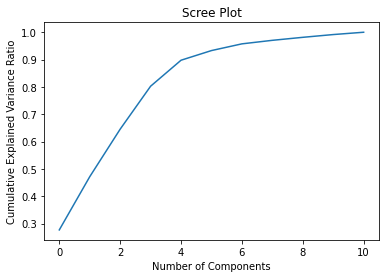

In [49]:
# Plot the cumulative explained variance ratio as a function of the number of components
plt.plot(cumulative_explained_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()



In [45]:
cumulative_explained_variance_ratio

array([0.27679208, 0.4713982 , 0.64541034, 0.80252258, 0.89764954,
       0.93295614, 0.95752678, 0.97044332, 0.981411  , 0.99153016,
       1.        ])

Part 5

Application of three different Machine Learning methods, using the 2, 4, 5 principal components resulting from PCA.

In [30]:
# prepare data
X = df.drop(columns=['DEATH_EVENT', 'time', 'dummy'])
y = df['DEATH_EVENT']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the data and transform X
X_pca = pca.fit_transform(X)

# initialize results list
results = []

# repeat process 100 times
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2)
    model = SVC(kernel='rbf')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # calculate metrics
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_pred)
    tp_rate = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
    tn_rate = np.sum((y_pred == 0) & (y_test == 0)) / np.sum(y_test == 0)
    
    # append results to list
    results.append([mcc, f1, acc, tp_rate, tn_rate, pr_auc, roc_auc])

# calculate mean of each metric and create dataframe
results_df = pd.DataFrame(results, columns=['MCC', 'F1 Score', 'Accuracy', 'TPR', 'TNR', 'PR AUC', 'ROC AUC'])
mean_results = results_df.mean()
final_results3 = pd.DataFrame(round(mean_results, 3)).T
final_results3.index = ['SVC(radial)-PCA=2 (stratified_split, MinMaxScaler, iter=1000)']

final_results3
# final_results_PCA2 = pd.concat([final_results_PCA2, final_results3])


In [31]:
final_results_PCA2


,MCC,F1 Score,Accuracy,TPR,TNR,PR AUC,ROC AUC
"Random Forest-PCA=2 (stratified_split, MinMaxScaler, iter=1000)",0.092,0.325,0.635,0.283,0.799,0.454,0.541
"GradientBoostingClassifier-PCA=2 (stratified_split, MinMaxScaler, iter=1000)",0.127,0.331,0.656,0.274,0.833,0.471,0.554
"SVC(radial)-PCA=2 (stratified_split, MinMaxScaler, iter=1000)",-0.002,0.000,0.683,0.000,0.999,0.651,0.499


In [45]:
# prepare data
X = df.drop(columns=['DEATH_EVENT', 'time', 'dummy'])
y = df['DEATH_EVENT']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Initialize PCA with 2 components
pca = PCA(n_components=4)

# Fit PCA to the data and transform X
X_pca = pca.fit_transform(X)

# initialize results list
results = []

# repeat process 100 times
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2)
    model = SVC(kernel='rbf')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # calculate metrics
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_pred)
    tp_rate = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
    tn_rate = np.sum((y_pred == 0) & (y_test == 0)) / np.sum(y_test == 0)
    
    # append results to list
    results.append([mcc, f1, acc, tp_rate, tn_rate, pr_auc, roc_auc])

# calculate mean of each metric and create dataframe
results_df = pd.DataFrame(results, columns=['MCC', 'F1 Score', 'Accuracy', 'TPR', 'TNR', 'PR AUC', 'ROC AUC'])
mean_results = results_df.mean()
final_results4 = pd.DataFrame(round(mean_results, 3)).T
final_results4.index = ['SVM(radial)-PCA=4 (stratified_split, MinMaxScaler, iter=1000)']

final_results4
# final_results_PCA4 = pd.concat([final_results_PCA4, final_results4])


In [46]:
final_results_PCA4

,MCC,F1 Score,Accuracy,TPR,TNR,PR AUC,ROC AUC
"Random Forest-PCA=4 (stratified_split, MinMaxScaler, iter=1000)",0.104,0.333,0.640,0.289,0.803,0.462,0.546
"GradientBoostingClassifier-PCA=4 (stratified_split, MinMaxScaler, iter=1000)",0.067,0.303,0.628,0.261,0.798,0.436,0.529
"SVM(radial)-PCA=4 (stratified_split, MinMaxScaler, iter=1000)",-0.027,0.006,0.673,0.004,0.983,0.554,0.494


In [56]:
# prepare data
X = df.drop(columns=['DEATH_EVENT', 'time', 'dummy'])
y = df['DEATH_EVENT']
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Initialize PCA with 2 components
pca = PCA(n_components=5)

# Fit PCA to the data and transform X
X_pca = pca.fit_transform(X)

# initialize results list
results = []

# repeat process 100 times
for i in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2)
    model = SVC(kernel='rbf')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # calculate metrics
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y_test, y_pred)
    tp_rate = np.sum((y_pred == 1) & (y_test == 1)) / np.sum(y_test == 1)
    tn_rate = np.sum((y_pred == 0) & (y_test == 0)) / np.sum(y_test == 0)
    
    # append results to list
    results.append([mcc, f1, acc, tp_rate, tn_rate, pr_auc, roc_auc])

# calculate mean of each metric and create dataframe
results_df = pd.DataFrame(results, columns=['MCC', 'F1 Score', 'Accuracy', 'TPR', 'TNR', 'PR AUC', 'ROC AUC'])
mean_results = results_df.mean()
final_results5 = pd.DataFrame(round(mean_results, 3)).T
final_results5.index = ['SVC(radial)-PCA=5 (stratified_split, MinMaxScaler, iter=1000)']

final_results5
# final_results_PCA5 = pd.concat([final_results_PCA5, final_results5])


In [57]:
final_results_PCA5

,MCC,F1 Score,Accuracy,TPR,TNR,PR AUC,ROC AUC
"RandomForestClassifier-PCA=5 (stratified_split, MinMaxScaler, iter=1000)",0.121,0.342,0.649,0.294,0.814,0.471,0.554
"GradientBoostingClassifier-PCA=5 (stratified_split, MinMaxScaler, iter=1000)",0.080,0.315,0.632,0.272,0.798,0.446,0.535
"SVC(radial)-PCA=5 (stratified_split, MinMaxScaler, iter=1000)",-0.019,0.060,0.663,0.038,0.952,0.421,0.495


In [58]:
final_results_PCA = pd.concat([final_results_PCA2, final_results_PCA4])
final_results_PCA = pd.concat([final_results_PCA, final_results_PCA5])

In [59]:
final_results_PCA

,MCC,F1 Score,Accuracy,TPR,TNR,PR AUC,ROC AUC
"Random Forest-PCA=2 (stratified_split, MinMaxScaler, iter=1000)",0.092,0.325,0.635,0.283,0.799,0.454,0.541
"GradientBoostingClassifier-PCA=2 (stratified_split, MinMaxScaler, iter=1000)",0.127,0.331,0.656,0.274,0.833,0.471,0.554
"SVC(radial)-PCA=2 (stratified_split, MinMaxScaler, iter=1000)",-0.002,0.000,0.683,0.000,0.999,0.651,0.499
"Random Forest-PCA=4 (stratified_split, MinMaxScaler, iter=1000)",0.104,0.333,0.640,0.289,0.803,0.462,0.546
"GradientBoostingClassifier-PCA=4 (stratified_split, MinMaxScaler, iter=1000)",0.067,0.303,0.628,0.261,0.798,0.436,0.529
"SVM(radial)-PCA=4 (stratified_split, MinMaxScaler, iter=1000)",-0.027,0.006,0.673,0.004,0.983,0.554,0.494
"RandomForestClassifier-PCA=5 (stratified_split, MinMaxScaler, iter=1000)",0.121,0.342,0.649,0.294,0.814,0.471,0.554
"GradientBoostingClassifier-PCA=5 (stratified_split, MinMaxScaler, iter=1000)",0.080,0.315,0.632,0.272,0.798,0.446,0.535
"SVC(radial)-PCA=5 (stratified_split, MinMaxScaler, iter=1000)",-0.019,0.060,0.663,0.038,0.952,0.421,0.495
